In [107]:
# !pip install opencv-python

In [108]:
import cv2  
import numpy as np
import matplotlib.pyplot as plt
import os
from os.path import isfile, join

FPS: 30 
Frame Size: (1280, 720)
Frame count: 105


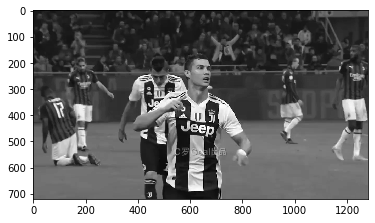

In [176]:
#Read the video
# path = 'input.gif'
path = 'Ronaldo.mp4'
cap=cv2.VideoCapture(path)

#Getting FPS of video
fps = int(cap.get(cv2.CAP_PROP_FPS))
print('FPS: {} '.format(fps))

#Getting Frame size of video
fsize = (int(cap.get(cv2.CAP_PROP_FRAME_WIDTH)),
        int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT)))
print('Frame Size: {}'.format(fsize))

#Getting Frame count
frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
duration = frame_count/fps
print('Frame count: {}'.format(frame_count))

#Read the First frame with face
cap.set(1,1)

ret, frame = cap.read()
# frame= frame[:,200:1000]
gray=cv2.cvtColor(frame,cv2.COLOR_BGR2GRAY)
plt.imshow(gray,cmap='gray')

Detected Face rectangles: 
 [[604 181 103 103]
 [452 232  64  64]]


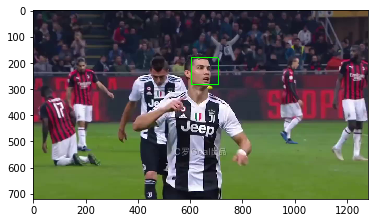

In [177]:
face = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')

def detectFace(gray):
    faces = face.detectMultiScale(gray,minNeighbors=4, minSize=(50, 50))
    if  len(faces)==0:
        return 0,0,0,0
    print('Detected Face rectangles: \n',faces)
    return faces[0]

x,y,w,h = detectFace(gray)
img = cv2.rectangle(frame, (x, y), (x+w, y+h), (0, 255, 0), 2)
        
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
# cv2.imwrite('facedetect.jpg',img)


In [168]:
c, r, w, h = detectFace(gray)
p0 = []
num = 4


for i in range(num-1):
    p0_temp = np.random.rand(1,2)*(w/2,h/2) + (c+w/4,r+h/4)
    p0.append(p0_temp)

#finding points in the rectangle to track
# p0.append([[c, r]])
# p0.append([[c+w, r]])
# p0.append([[c, r+h]])
# p0.append([[c+w, r+h]])

p0_temp = [[c+w/2, r+h/2]]
p0.append(p0_temp)
p0 = np.array(p0).astype('float32')
print('Tracking Points:\n',p0)


#for Optical flow track the centre of rectangle
pt = (0, c + w/2, r + h/ 2)
print('Rectangle centre point:\n',pt)  # Write as 0,pt_x,pt_y


Detected Face rectangles: 
 [[405 182 101 101]
 [250 234  64  64]]
Tracking Points:
 [[[461.63898 210.05482]]

 [[458.24667 248.03429]]

 [[474.39648 246.88142]]

 [[455.5     232.5    ]]]
Rectangle centre point:
 (0, 455.5, 232.5)


In [169]:
savepath = './Rfolder/'
# savepath = './Face/'


# Parameters for lucas kanade optical flow
lk_params = dict( winSize  = (30,30),
                  maxLevel = 2,
                  criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03))

# Create some random colors
color = np.random.randint(0,255,(num,3))
# frame= frame[:,200:1000]
# Take first frame and find corners in it
ret, old_frame = ret, frame

old_gray = cv2.cvtColor(old_frame, cv2.COLOR_BGR2GRAY)
cv2.imshow('first',old_gray)

mask = np.zeros_like(img)
count = 1
cap.set(1,1)
while(cap.isOpened()):
    count +=1
    ret,frame = cap.read()
#     frame= frame[:,200:1000]
    fac = detectFace(frame)
    if not ret or np.sum(fac)==0:
        break
    (x, y, w, h) = fac
    frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # calculate optical flow
    p1, st, err = cv2.calcOpticalFlowPyrLK(old_gray, frame_gray, p0, None, **lk_params)

    # Select good points
    good_new = p1[st==1]
    good_old = p0[st==1]

    # draw the tracks
    for i,(new,old) in enumerate(zip(good_new,good_old)):
        a,b = new.ravel()
        c,d = old.ravel()
        mask = cv2.line(mask, (a,b),(c,d), color[i].tolist(), 2)
        frame = cv2.circle(frame,(a,b),5,color[i].tolist(),-1)
#     print(np.size(mask))
#     print(np.size(frame))
    img1 = cv2.add(frame,mask)
    img1 = cv2.rectangle(img1, (x, y), (x+w, y+h), (0, 255, 0), 2)
    cv2.imwrite(os.path.join(savepath , '{}.jpg'.format(count)),img1)
#     cv2.imshow('frame',img1)

    # Now update the previous frame and previous points
    old_gray = frame_gray.copy()
    p0 = good_new.reshape(-1,1,2)
    

    # Use face detector else use optical flow
    if w != 0 and h != 0:
        pos = (x + w/2, y + h/2)
    else:
        pos = sum(zip(*p0)[0]) / num

    pt = (count, pos[0], pos[1])
    
#     if count==frame_count:
        
#     count +=1
    
cap.release()
cv2.destroyAllWindows()



Detected Face rectangles: 
 [[405 182 101 101]
 [250 234  64  64]]
Detected Face rectangles: 
 [[262 237  65  65]
 [408 172  99  99]]
Detected Face rectangles: 
 [[401 160  96  96]]
Detected Face rectangles: 
 [[399 148 103 103]]
Detected Face rectangles: 
 [[393 147 107 107]]
Detected Face rectangles: 
 [[397 160 100 100]
 [331 518  57  57]
 [354 152 126 126]]
Detected Face rectangles: 
 [[378 155 114 114]]
Detected Face rectangles: 
 [[393 170 112 112]]
Detected Face rectangles: 
 [[484 518  56  56]
 [378 517  66  66]]
Detected Face rectangles: 
 [[371 174 108 108]]


In [171]:
pathIn= 'Rfolder/'
# pathIn= 'Face/'
pathOut = 'rvideo.avi'
# pathOut = 'facevideo.avi'
fps = 5
frame_array = []
files = [f for f in os.listdir(pathIn) if f.endswith(".jpg")]

#for sorting the file names properly
files = sorted(files,key=lambda x: int(os.path.splitext(x)[0]))

# print(lsorted)
for i in range(len(files)):
    filename=pathIn + files[i]
    #reading each files
    img = cv2.imread(filename)
    height, width, layers = img.shape
    size = (width,height)
    
    #inserting the frames into an image array
    frame_array.append(img)
    out = cv2.VideoWriter(pathOut,cv2.VideoWriter_fourcc(*'DIVX'), fps, size)
    for i in range(len(frame_array)):
        out.write(frame_array[i])
out.release()
